# Inferencing a Time Series Model using Channel Independence PatchTST

<ul>
<li>Contributors: IBM AI Research team and IBM Research Technology Education team
<li>Contact for questions and technical support: IBM.Research.JupyterLab@ibm.com
<li>Provenance: IBM Research
<li>Version: 1.0.0
<li>Release date: 
<li>Compute requirements: 4 CPU
<li>Memory requirements: 16 GB
<li>Notebook set: Time Series Foundation Model
</ul>

# Summary

**Patch Time Series Transformer (PatchTST)** is a new method for long-term forecasting based on Transformer modeling. In PatchTST, a time series is segmented into subseries-level patches that are served as input tokens to Transformer. PatchTST was first proposed in 2023 in [this paper](https://arxiv.org/pdf/2211.14730.pdf). It can achieve state-of-the-art results when compared to other Transformer-based models.

**Channel Independence PatchTST** is a variant of PatchTST where each channel contains a single univariate time series that shares the same embedding and Transformer weights across all the series.

This notebook is the last of three notebooks that should be run in sequence. After running the first notebook, `01_patch_tst_pretrain.ipynb`, a pretrained model was saved in your private storage. The second notebook, `02_patch_tst_fine_tune.ipynb`, loaded the pretrained model and created a fine tuned model, which was also saved in your private storage. This notebook demonstrates inferencing on test data using the fine tuned model. The goal of this demonstration is to forecast the future sensor values (load, oil temperature) of an electric transformer using test data from the ETTh1 benchmark dataset.

# Table of Contents

* <a href="#TST3_intro">Channel Independence PatchTST</a>
* <a href="#TST3_codes">Code Samples</a>
    * <a href="#TST3_import">Step 1. Imports</a>
    * <a href="#TST3_pipeln">Step 2. Load model and construct forecasting pipeline</a>
    * <a href="#TST3_datast">Step 3. Load and prepare datasets </a>
    * <a href="#TST3_forecs">Step 4. Generate forecasts </a>
    * <a href="#TST3_perfor">Step 5. Evaluate performance </a>
    * <a href="#TST3_visual">Step 6. Plot results </a>
* <a href="#TST3_concl">Conclusion</a>
* <a href="#TST3_learn">Learn More</a>

<a id="TST3_intro"></a>
# Channel Independence PatchTST

**Channel Independence PatchTST** is an efficient design of Transformer-based models for multivariate time series forecasting and self-supervised representation learning. It is demonstrated in the following diagram. It is based on two key components:

- segmentation of time series into subseries-level patches that are served as input tokens to Transformer

- channel independence where each channel contains a single univariate time series that shares the same embedding and Transformer weights across all the series.

Patching design naturally has three-fold benefit: local semantic information is retained in the embedding; computation and memory usage of the attention maps are quadratically reduced given the same look-back window; and the model can attend longer history.

Channel independence allows each time series to have its own embedding and attention maps while sharing the same model parameters across different channels.

<div> <img src="./data/figures/patchTST.png" alt="Drawing" style="width: 600px;"/></div>

<a id="TST3_codes"></a>
# Code Samples

This section includes documentation and code samples to demonstrate the use of the toolkit for inferencing.

<a id="TST3_import"></a>
## Step 1. Imports

In [1]:
import pandas as pd

from transformers.models.patchtst import PatchTSTForPrediction
from tsfmservices.toolkit.time_series_forecasting_pipeline import (
    TimeSeriesForecastingPipeline,
)
from tsfmservices.toolkit.time_series_preprocessor import TimeSeriesPreprocessor
from tsfmservices.toolkit.util import select_by_index
from tsfmservices.toolkit.visualization import plot_ts_forecasting

# Customized IBM stylesheet for plots - dark background
# %run '/opt/ibm/visualization/plotly/plotly_template_dark.ipynb'

<a id="TST3_pipeln"></a>
## Step 2. Load model and construct forecasting pipeline

 Please adjust the following parameters to suit your application:
 - timestamp_column: column name containing timestamp information, use None if there is no such column
 - id_columns: List of column names specifying the IDs of different time series. If no ID column exists, use []
 - forecast_columns: List of columns to be modeled
 - finetuned_model_path: Path to the finetuned model
   

In [2]:
timestamp_column = "date"
id_columns = []
forecast_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
finetuned_model_path = "model/forecasting"

In [3]:
model = PatchTSTForPrediction.from_pretrained(finetuned_model_path)
# model.model.mask_input = False
forecast_pipeline = TimeSeriesForecastingPipeline(
    model=model,
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    input_columns=forecast_columns,
)
context_length = model.config.context_length

tsp = TimeSeriesPreprocessor.from_pretrained("preprocessor")

<a id="TST3_datast"></a>
## Step 3. Load and prepare datasets

The specific data loaded here is Electricity Transformer Temperature (ETT) data - including load, oil temperature in an electric transformer. In the next cell, please adjust the following parameters to suit your application:

 - dataset_path: path to local .csv file, or web address to a csv file for the data of interest. Data is loaded with pandas, so anything supported by pd.read_csv is supported: (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html).
 - test_start_index, test_end_index: the start and end indices in the loaded data which delineate the test data.


In [4]:
dataset_path = (
    "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh2.csv"
)
test_start_index = 12 * 30 * 24 + 4 * 30 * 24 - context_length
test_end_index = 12 * 30 * 24 + 8 * 30 * 24

In [5]:
data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

test_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=test_start_index,
    end_index=test_end_index,
)
test_data = tsp.preprocess(test_data)

In [6]:
test_data.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,__id
11008,2017-10-02 16:00:00,-0.832612,-2.675638,-0.366989,-2.270636,-1.969397,0.034774,0.107294,0
11009,2017-10-02 17:00:00,-0.824573,-2.675638,-0.349490,-2.448201,-2.013137,0.034774,0.145276,0
11010,2017-10-02 18:00:00,-0.511907,-2.675638,-0.238209,-2.172908,-1.477909,0.034774,0.126285,0
11011,2017-10-02 19:00:00,-1.049096,-2.675638,-0.521217,-2.714549,-1.863816,0.034774,0.012471,0
11012,2017-10-02 20:00:00,-0.776530,-2.675638,-0.435383,-2.910004,-1.572070,0.034774,0.031419,0


<a id="TST3_forecs"></a>
## Step 4. Generate forecasts

 Note that the ouput will consist of a Pandas dataframe with the following structure.
 If you have specified timestamp and/or ID columns they will be included. The forecast
 columns will be named `{forecast column}_prediction`, for each `{forecast column}` that was
 specified.
 Each forecast column will be a vector of values with length equal to the prediction horizon
 that was specified when the model was trained.

In [7]:
forecasts = forecast_pipeline(test_data)
forecasts.head()

,date,HUFL_prediction,HULL_prediction,MUFL_prediction,MULL_prediction,LUFL_prediction,LULL_prediction,OT_prediction,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2017-10-23 23:00:00,"[-1.0471887588500977, -1.0674819946289062, -1....","[-2.1400651931762695, -2.144653558731079, -2.1...","[-0.4619007706642151, -0.48131313920021057, -0...","[-2.4332711696624756, -2.243785858154297, -2.2...","[-1.9695631265640259, -1.9781545400619507, -1....","[0.09872758388519287, 0.13173142075538635, 0.1...","[-0.45469939708709717, -0.4729803204536438, -0...","[-0.9769346117973328, -0.9528172016143799, -0....","[-2.67563796043396, -2.67563796043396, -2.6756...","[-0.37653934955596924, -0.37333613634109497, -...","[-2.0927388668060303, -2.2706356048583984, -2....","[-1.967241883277893, -2.1462976932525635, -1.7...","[0.0977693721652031, -0.034485891461372375, 0....","[-0.6323868632316589, -0.6703246831893921, -0...."
1,2017-10-24 00:00:00,"[-1.0814071893692017, -1.000411868095398, -1.1...","[-2.3694279193878174, -2.38236141204834, -2.38...","[-0.4749853014945984, -0.43140164017677307, -0...","[-2.273848295211792, -2.0972306728363037, -2.2...","[-2.0247035026550293, -1.9933781623840332, -2....","[0.07478410005569458, 0.09837137162685394, 0.0...","[-0.4970269203186035, -0.5069565773010254, -0....","[-0.9528172016143799, -0.9528172016143799, -0....","[-2.67563796043396, -2.67563796043396, -2.6756...","[-0.37333613634109497, -0.47827035188674927, -...","[-2.2706356048583984, -2.243802070617676, -2.1...","[-2.1462976932525635, -1.7030754089355469, -1....","[-0.034485891461372375, 0.12672606110572815, 0...","[-0.6703246831893921, -0.7272531390190125, -0...."
2,2017-10-24 01:00:00,"[-1.210005283355713, -1.1031949520111084, -1.3...","[-2.5414774417877197, -2.4867234230041504, -2....","[-0.5381877422332764, -0.4888448417186737, -0....","[-2.3967995643615723, -2.26922607421875, -2.49...","[-2.0923259258270264, -2.062915086746216, -2.1...","[0.03843916952610016, 0.06660197675228119, 0.0...","[-0.5703141689300537, -0.5493237376213074, -0....","[-0.9528172016143799, -0.7444687485694885, -1....","[-2.67563796043396, -2.67563796043396, -2.6756...","[-0.47827035188674927, -0.37968331575393677, -...","[-2.243802070617676, -2.128516912460327, -2.56...","[-1.7030754089355469, -1.6823902130126953, -1....","[0.12672606110572815, 0.11916186660528183, 0.2...","[-0.7272531390190125, -0.7651479840278625, -0...."
3,2017-10-24 02:00:00,"[-1.179441213607788, -1.1103092432022095, -1.1...","[-2.5241663455963135, -2.6033713817596436, -2....","[-0.5530601143836975, -0.5020198225975037, -0....","[-2.4287641048431396, -2.420628547668457, -2.4...","[-1.9898751974105835, -2.02323055267334, -2.01...","[0.05309256166219711, 0.059379592537879944, 0....","[-0.6292417049407959, -0.5932251214981079, -0....","[-0.7444687485694885, -1.4017665386199951, -0....","[-2.67563796043396, -2.67563796043396, -2.6756...","[-0.37968331575393677, -0.7549904584884644, -0...","[-2.128516912460327, -2.563485860824585, -2.53...","[-1.6823902130126953, -1.7397053241729736, -2....","[0.11916186660528183, 0.28049200773239136, 0.2...","[-0.7651479840278625, -0.8031288981437683, -0...."
4,2017-10-24 03:00:00,"[-1.1513924598693848, -0.9799333810806274, -1....","[-2.648386001586914, -2.6715118885040283, -2.7...","[-0.5556620359420776, -0.44359979033470154, -0...","[-2.567776679992676, -2.475558280944824, -2.48...","[-1.8915470838546753, -1.9490196704864502, -1....","[0.05736367404460907, 0.06174261122941971, 0.0...","[-0.6716929078102112, -0.6018509864807129, -0....","[-1.4017665386199951, -0.9849737286567688, -0....","[-2.67563796043396, -2.67563796043396, -2.6756...","[-0.7549904584884644, -0.4719233810901642, -0....","[-2.563485860824585, -2.5369837284088135, -1.9...","[-1.7397053241729736, -2.063772678375244, -2.0...","[0.28049200773239136, 0.28049200773239136, 0.1...","[-0.8031288981437683, -0.8600142002105713, -0...."


<a id="TST3_perfor"></a>
## Step 5. Evaluate performance


In [8]:
from tsevaluate.multivalue_timeseries_evaluator import CrossTimeSeriesEvaluator


labels_ = forecasts[id_columns + [timestamp_column] + forecast_columns]
forecasts_ = forecasts.drop(columns=forecast_columns)

eval = CrossTimeSeriesEvaluator(
    timestamp_column=timestamp_column,
    prediction_columns=[f"{c}_prediction" for c in forecast_columns],
    label_columns=forecast_columns,
    metrics_spec=["mse", "smape", "rmse", "mae"],
    multioutput="uniform_average",
)
eval.evaluate(labels_, forecasts_)

/opt/app-root/lib64/python3.9/site-packages/tsevaluate/multivalue_timeseries_evaluator.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[self.__class__._TMP_ID_COL] = self.__class__._TMP_ID_VAL


,avg_mse,avg_smape,avg_rmse,avg_mae
0,0.286712,0.540242,0.487434,0.343528


<a id="TST3_visual"></a>
## Step 6. Plot results



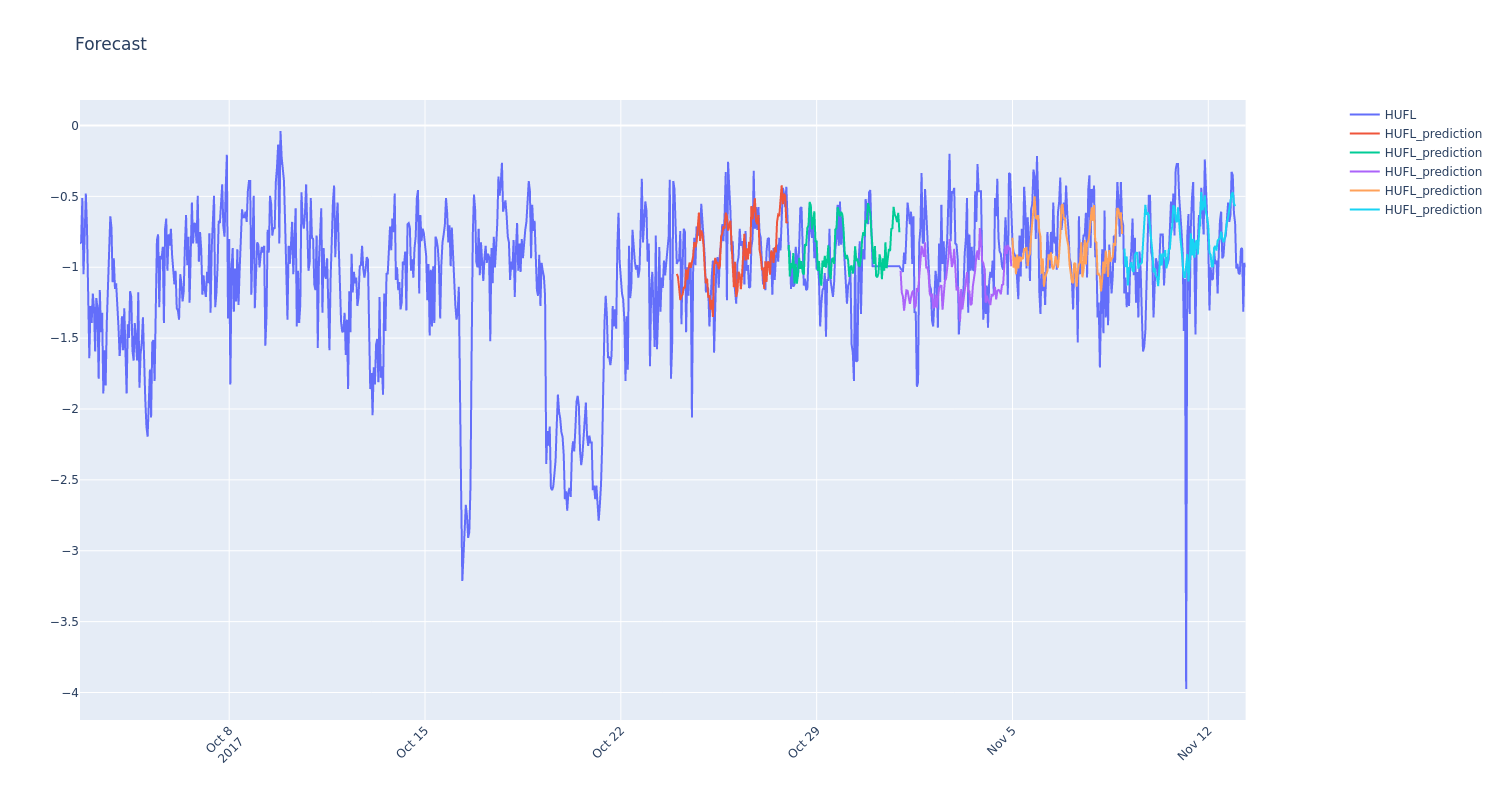

In [9]:
plot_ts_forecasting(
        test_data,
        forecasts_,
        forecast_columns = ["HUFL"],
        timestamp_column = timestamp_column,
        periodicity = "1h",
        prediction_length = model.config.prediction_length,
        context_length = context_length,
        plot_start = 0,
        plot_end = 1000,
        plot_stride = model.config.prediction_length,
        title = "Forecast",
        fig_size = (15, 8),
        plot_type = "plotly"
)

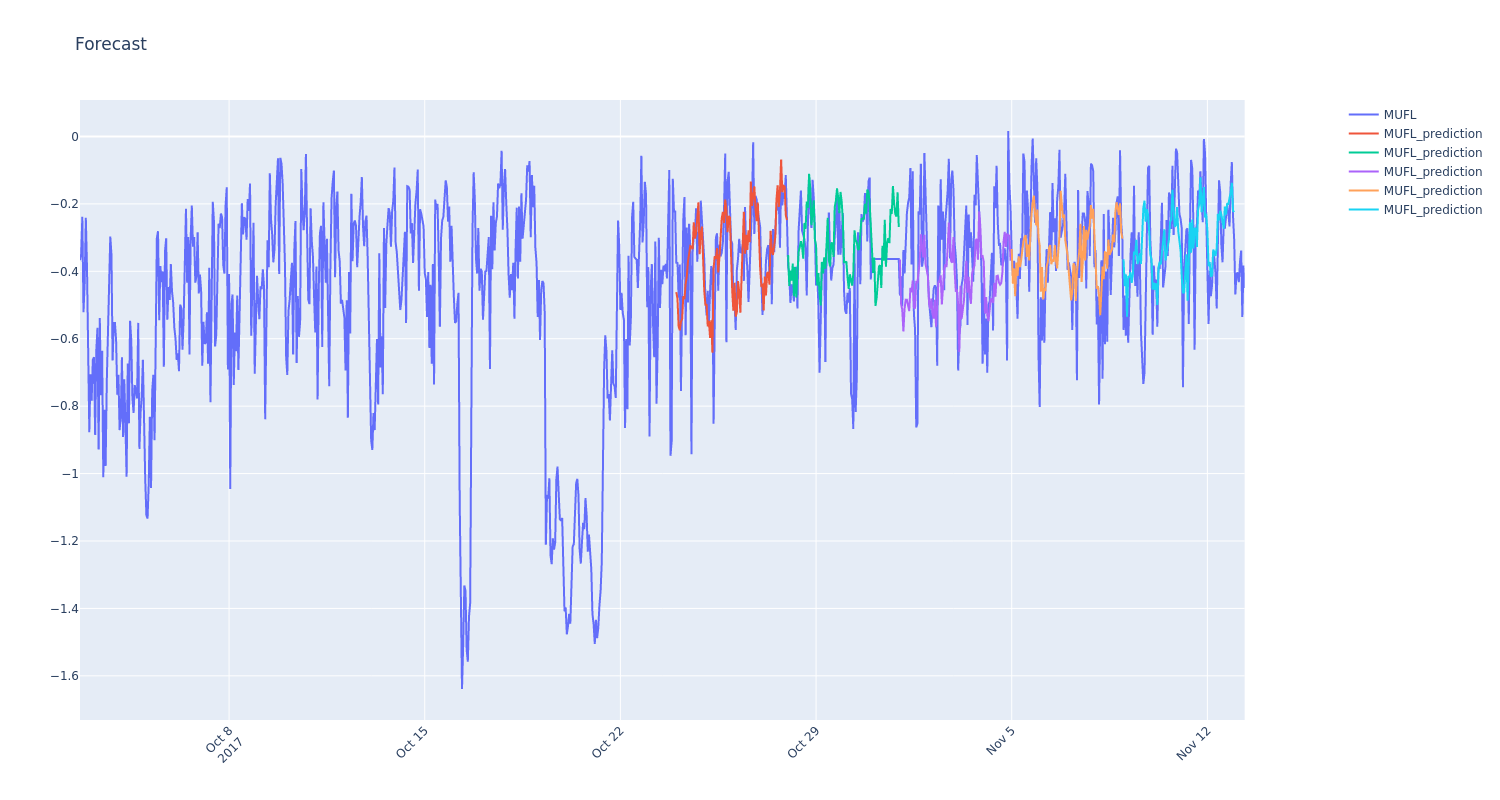

In [15]:
plot_ts_forecasting(
        test_data,
        forecasts_,
        forecast_columns = ["MUFL"],
        timestamp_column = timestamp_column,
        periodicity = "1h",
        prediction_length = model.config.prediction_length,
        context_length = context_length,
        plot_start = 0,
        plot_end = 1000,
        plot_stride = model.config.prediction_length,
        title = "Forecast",
        fig_size = (15, 8),
        plot_type = "plotly"
)

<a id="TST3_concl"></a>
# Conclusion

This notebook showed how to perform inferencing in a Channel Independence PatchTST model. This is the last of three notebooks that were run in sequence using training and test data from the ETTh1 benchmark dataset, which represents sensor data from an electric transformer.

The first notebook, `01_patch_tst_pretrain.ipynb`, created a pretrained model that was saved in your private storage. The second notebook, `02_patch_tst_fine_tune.ipynb`, loaded the pretrained model and created a fine tuned model, which was also saved in your private storage. This notebook performed inferencing on the fine tuned model. The goal of this demonstration was to forecast the future sensor values (load, oil temperature) of an electric transformer using test data.

<a id="TST3_learn"></a>
# Learn More

[This paper](https://arxiv.org/pdf/2211.14730.pdf) provides detailed information on Channel Independence PatchTST, including evaluations of its performance on 8 popular datasets, including Weather, Traffic, Electricity, ILI and 4 Electricity Transformer Temperature datasets (ETTh1, ETTh2, ETTm1, ETTm2). These publicly available datasets have been extensively utilized for benchmarking. We featured one of them (ETTh1) in this notebook.

If you have any questions or wish to schedule a technical deep dive, contact us by email at IBM.Research.JupyterLab@ibm.com.

© 2023 IBM Corporation